In [1]:
# importing all necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import yfinance as yf  # Import yfinance library for fetching historical ticker data
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from arch import arch_model
import warnings
warnings.simplefilter('ignore')


# Task 1

### Task 1.1

In [3]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('content/IBM_202001.csv.gz', compression='gzip')

original_length = len(df)
original_length


# F1
# Removing entries with either transaction price, transaction size, ask price, ask size, bid price or bid size ≤ 0
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | (df['PRICE'] <= 0) | (df['SIZE'] <= 0)
df = df[~df_out].reset_index(drop=True)

# calculating no. of entries removed in f1
f1 = original_length - len(df)
f1_cleaned_length = len(df)


# F2
# Removing entries with either transaction price, transaction size, ask price, ask size, bid price or bid size ≤ 0
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | (df['PRICE'] <= 0) | (df['SIZE'] <= 0)
df = df[~df_out].reset_index(drop=True)

# calculating no. of entries removed in f1
f1 = original_length - len(df)
f1_cleaned_length = len(df)


# F2
# Remove entries with negative bid-ask spread
df['SPREAD'] = df['NBO'] - df['NBB']
df = df[~(df['SPREAD'] <= 0)].reset_index(drop=True)

f2 = f1_cleaned_length - len(df)
f2_cleaned_length = len(df)


# F3
df['Stamp'] = pd.to_datetime(df['DATE'], format='%d%b%Y') + df['TIME_M'].apply(lambda x: pd.Timedelta(x,unit='sec'))
# Group by 'DATE', 'TIME', 'EX', and 'BuySell'
df = df.groupby(['Stamp', 'DATE', 'EX', 'BuySell']).agg({
    'PRICE': 'median',
    'NBO': 'median',
    'NBB': 'median',
    'SIZE': 'sum',
    'NBOqty': 'sum',
    'NBBqty': 'sum'
}).reset_index()

f3 = f2_cleaned_length - len(df)
f3_cleaned_length = len(df)


# F4
# Remove entries for which the spread is more that 50 times the median spread on that day
df['SPREAD'] = df['NBO'] - df['NBB']

medspread = df['SPREAD'].median()
df = df[~(df['SPREAD'] > 50*medspread)].reset_index(drop=True)

f4 = f3_cleaned_length - len(df)
f4_cleaned_length = len(df)


# F5
## Delete entries with prices that are above the `ask' plus the bid–ask spread. 
## Similar for entries with prices below the `bid' minus the bid–ask spread
df_out = (df['PRICE'] > df['NBO'] + df['SPREAD']) | (df['PRICE'] < df['NBB'] - df['SPREAD'])
df = df[~df_out]

f5 = f4_cleaned_length - len(df)
f5_cleaned_length = len(df)


# Summary
summary = pd.DataFrame({
    'F1': [f1, f1/original_length*100],
    'F2': [f2, f2/original_length*100],
    'F3': [f3, f3/original_length*100],
    'F4': [f4, f4/original_length*100],
    'F5': [f5, f5/original_length*100],
}, index=['Number', 'Proportion'])

df.set_index('Stamp', drop=True, inplace = True)

summary.round(2)

,F1,F2,F3,F4,F5
Number,0.0,14375.00,222406.00,0.0,7063.00
Proportion,0.0,1.46,22.58,0.0,0.72


### Task 1.2

In [4]:
freqs = ['1S', '2S', '3S', '4S', '5S', '10S', '15S', '20S', '30S',
               '40S', '50S', '1T', '2T', '3T', '4T', '5T', '6T', '7T', '8T',
               '9T', '10T', '15T', '20T', '30T']
RVdf = pd.DataFrame(index=pd.unique(df['DATE']))
BVdf = pd.DataFrame(index=pd.unique(df['DATE']))
TRVdf = pd.DataFrame(index=pd.unique(df['DATE']))

def RV(ret):
    return (ret**2).resample('D').sum()

def BV(ret):
    ret = np.abs(ret)
    return (log_returns.abs().iloc[:-1] * log_returns.abs().shift(-1).iloc[:-1]).resample('D').sum()*np.pi/2

def TRV(ret, percentile):
    u = ret.quantile(percentile)
    return (ret**2).where(ret.abs() <= u).resample('D').sum()

for f in freqs:
    resampled = df['PRICE'].resample(f).ohlc()['close']
    log_returns = np.log(resampled).diff().dropna()

    RVdf[f] = RV(log_returns)
    BVdf[f] = BV(log_returns)
    TRVdf[f] = TRV(log_returns, 0.975)

print('RVdf')
print(RVdf.head())
print('BRVdf')
print(BVdf.head())
print('TRVdf')
print(TRVdf.head())

RVdf
                 1S        2S        3S        4S        5S       10S  \
02JAN2020  0.000062  0.000072  0.000075  0.000079  0.000070  0.000069   
03JAN2020  0.000102  0.000135  0.000135  0.000137  0.000128  0.000107   
06JAN2020  0.000067  0.000085  0.000081  0.000082  0.000079  0.000064   
07JAN2020  0.000094  0.000121  0.000086  0.000094  0.000096  0.000079   
08JAN2020  0.000064  0.000086  0.000097  0.000103  0.000105  0.000089   

                15S       20S       30S       40S  ...        4T        5T  \
02JAN2020  0.000064  0.000058  0.000055  0.000053  ...  0.000071  0.000053   
03JAN2020  0.000090  0.000087  0.000079  0.000076  ...  0.000076  0.000060   
06JAN2020  0.000049  0.000046  0.000036  0.000036  ...  0.000026  0.000026   
07JAN2020  0.000063  0.000058  0.000056  0.000059  ...  0.000040  0.000033   
08JAN2020  0.000085  0.000075  0.000077  0.000066  ...  0.000050  0.000051   

                 6T        7T        8T        9T       10T       15T  \
02JAN2020  0.0

### Task 1.3


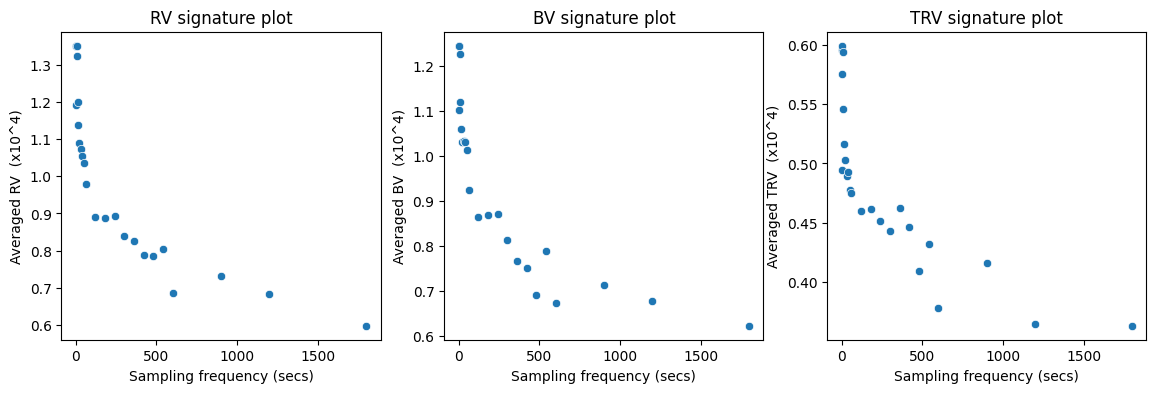

In [5]:
RVdf# Compute Average RVs across different days
RVav = RVdf.mean()*10000
BVav = BVdf.mean()*10000
TRVav = TRVdf.mean()*10000
# Convert index to integers (sec)
RVav.index
time = [0] + [pd.Timedelta(x).total_seconds() for x in RVav.index[1:]]

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(14,4))

sns.scatterplot(x=time,y=RVav,ax=axes[0])
axes[0].set_title('RV signature plot')
axes[0].set_xlabel('Sampling frequency (secs)')
axes[0].set_ylabel('Averaged RV  (x10^4)')


sns.scatterplot(x=time,y=BVav,ax=axes[1])
axes[1].set_title('BV signature plot')
axes[1].set_xlabel('Sampling frequency (secs)')
axes[1].set_ylabel('Averaged BV  (x10^4)')


sns.scatterplot(x=time,y=TRVav,ax=axes[2])
axes[2].set_title('TRV signature plot')
axes[2].set_xlabel('Sampling frequency (secs)')
axes[2].set_ylabel('Averaged TRV  (x10^4)')
plt.show()

# Task 2

### Task 2.1

In [6]:
student_id = 36629202  # Use your actual student ID here
random.seed(student_id)
djia_tickers = pd.read_csv('DowJones-Feb2022.csv')

djia_tickers = djia_tickers['Ticker'].unique().tolist()  # Get unique ticker symbols
djia_tickers.remove('DOW')  # Remove 'DOW' from the list of ticker symbols

# Randomly select 2 ticker symbols from the DJIA index
my_sample = sorted(random.sample(djia_tickers,2))
# my_sample = ['WBA', 'WMT']
startdate = '2010-01-01'
enddate = '2023-12-31'     # Specify end date for historical data

dfs = []
for ticker in my_sample:
    # Download historical ticker prices for the selected ticker symbols
    data = yf.download(ticker, start = startdate, end = enddate)
    data.rename(columns={"Adj Close": "price"}, inplace = True)
    data['return'] = np.log(data['price']/data['price'].shift(1)) # Log return
    data.dropna(inplace = True)
    dfs.append(data)

columns = [(ticker, col) for ticker in my_sample for col in data.columns]
data = pd.concat(dfs, axis=1)

# Assigning MultiIndex to columns
data.columns = pd.MultiIndex.from_tuples(columns)

data_train = data[data.index <= '2020-12-31']

# Choose ARMA parameters to minimize AIC
best_models = {}
for ticker in my_sample:
    model_p = pm.auto_arima(100*data_train[ticker]['return'],start_p=0, start_q=0, max_p=3, max_q=3,test='adf',
                        seasonal=False,trace=False,stepwise=False,with_intercept=True)
    print(f"Best-fitted ARMA model for {ticker}: ARMA{model_p.order} - AIC = {model_p.aic():.4f}")
    best_models[ticker] = model_p

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Best-fitted ARMA model for WBA: ARMA(2, 0, 2) - AIC = 11036.8653
Best-fitted ARMA model for WMT: ARMA(2, 0, 3) - AIC = 8810.5699


### Task 2.2

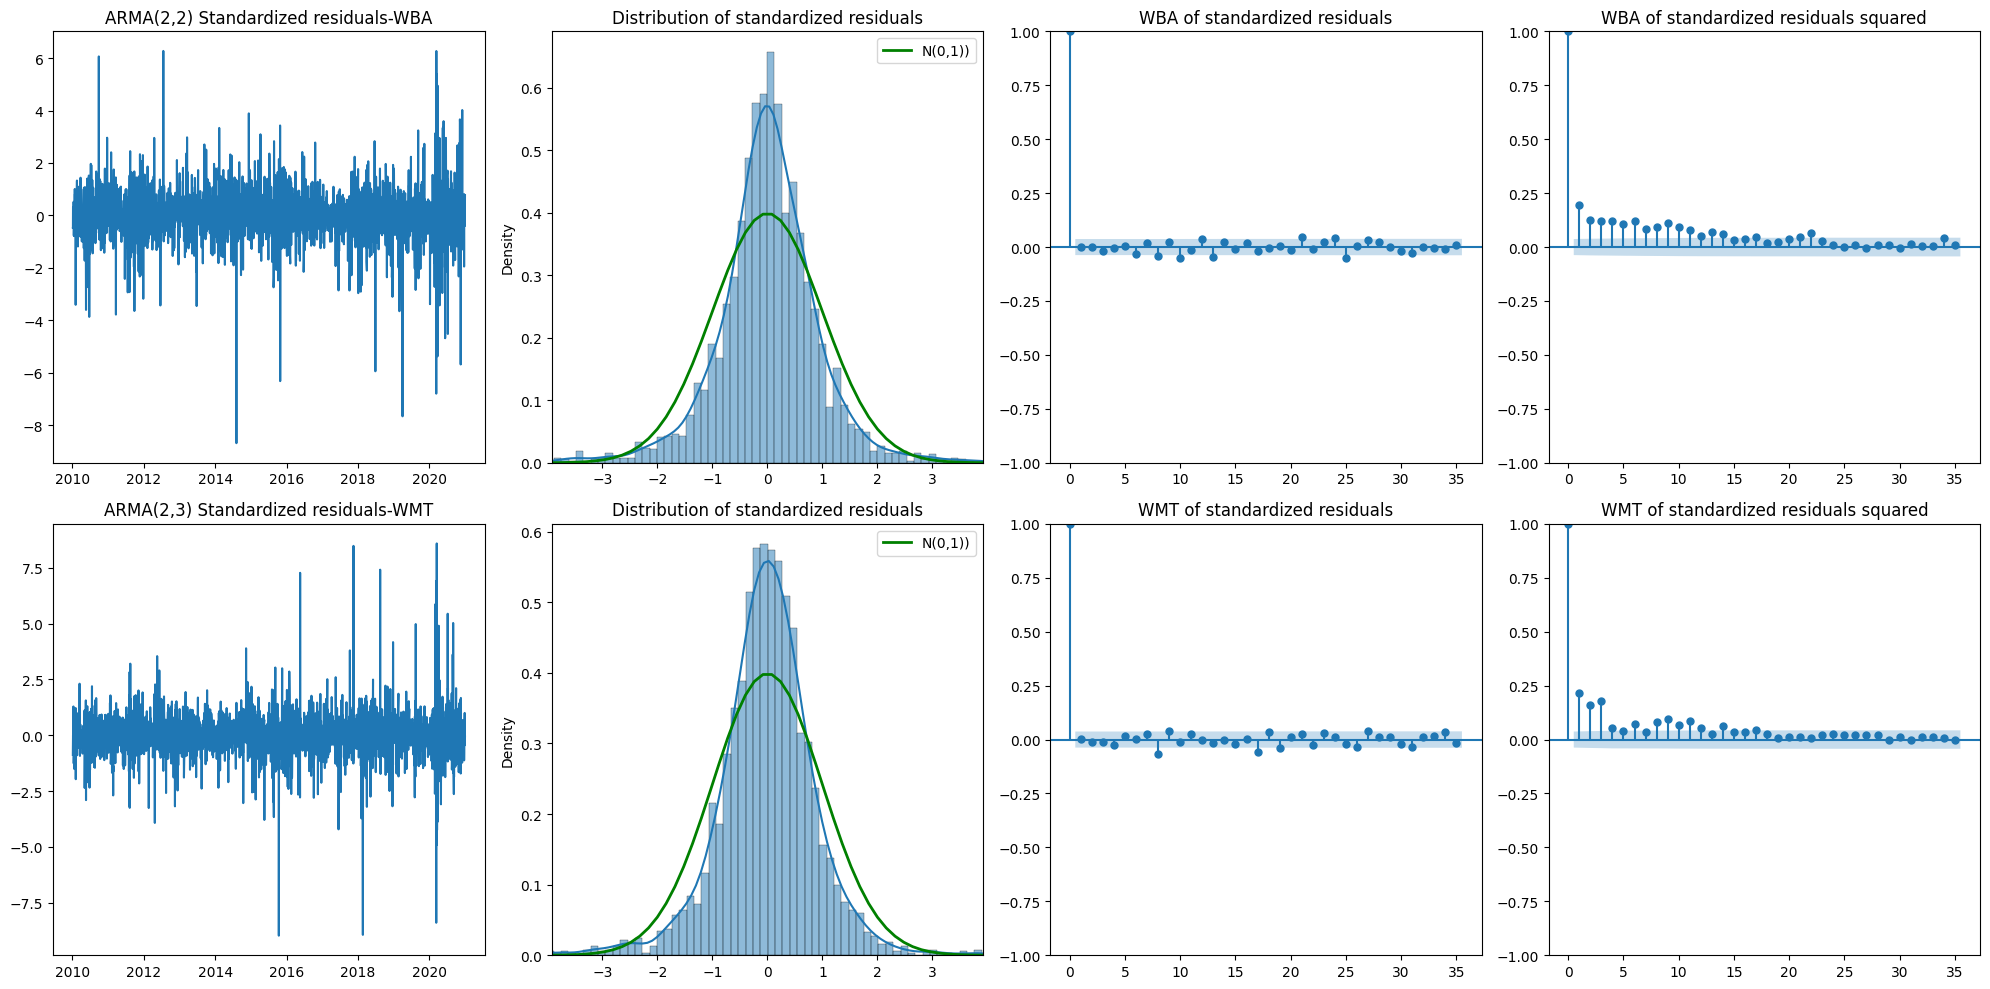

In [7]:
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(20,10))

for i,ticker in enumerate(my_sample):
    r = best_models[ticker].resid() # Extract residuals
    r = (r-r.mean())/r.std() # Standardized residuals
    p = best_models[ticker].order[0]
    q = best_models[ticker].order[2]


    # Time series plot of Standardized residuals
    axes[i, 0].plot(r, label='Standardized residuals')
    axes[i, 0].set_title(f'ARMA({p},{q}) Standardized residuals-{ticker}')


    # distribution of standardized residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.histplot(r,kde=True,stat='density',ax=axes[i,1])
    axes[i, 1].plot(r_range, norm_pdf, 'g', lw=2, label=f'N(0,1))')
    axes[i, 1].set_title('Distribution of standardized residuals')
    axes[i, 1].set_xlim(x_lim)
    axes[i, 1].legend()


    # ACF of standardized residuals
    plot_acf(r, ax = axes[i, 2], title = f'{ticker} of standardized residuals', alpha=0.05)


    # ACF plot
    plot_acf(r**2, ax = axes[i, 3], title = f'{ticker} of standardized residuals squared', alpha=0.05)

    plt.tight_layout()

### Task 2.3

In [8]:
garch_best_models = {}
for ticker in my_sample:
    aicVal=[]
    for p in range(0,4):
        for q in range(0,4):
            try:
                model = arch_model(y = 100*data_train[ticker]['return'],mean='AR',lags=best_models[ticker].order[0],vol='GARCH',p=p,o=0,q=q, dist='StudentsT')
                model = model.fit(update_freq=5, disp = False)
                aicVal.append([p, q, model.aic, model])
            except:
                continue
    aicVal = pd.DataFrame(aicVal, columns = ['p', 'q', 'aic', 'model'])
    garch_best_models[ticker] = aicVal.iloc[aicVal['aic'].argmin(),]
    print(f'Best-fittedAR(p)-GARCH(p*,q*)modelforWBA:AR({best_models[ticker].order[0]})-GARCH({garch_best_models[ticker]['p']},{garch_best_models[ticker]['q']})-AIC ={garch_best_models[ticker]['aic']:.4f}')


Best-fittedAR(p)-GARCH(p*,q*)modelforWBA:AR(2)-GARCH(1,1)-AIC =10137.8506
Best-fittedAR(p)-GARCH(p*,q*)modelforWBA:AR(2)-GARCH(3,0)-AIC =7743.4499


### Task 2.4

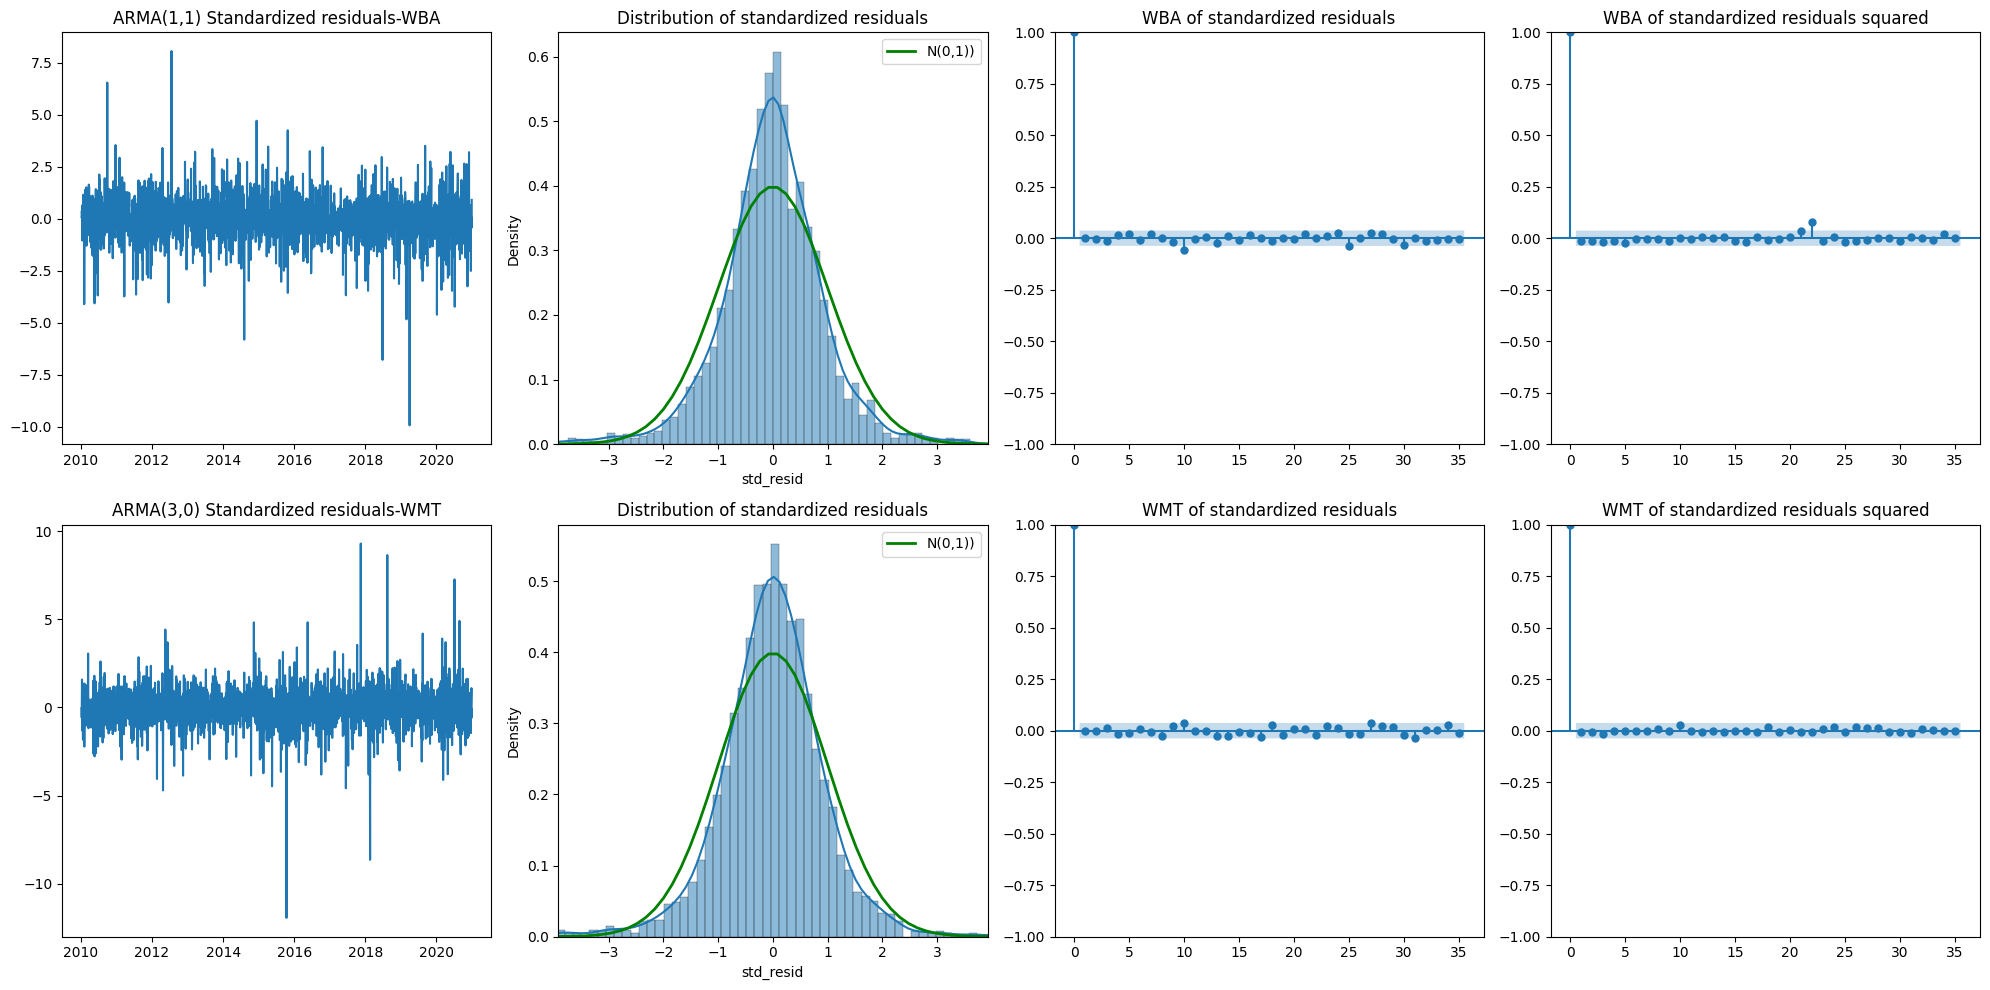

In [9]:
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(20,10))

for i,ticker in enumerate(my_sample):
    r = garch_best_models[ticker]['model'].std_resid.dropna()
    p = garch_best_models[ticker]['p']
    q = garch_best_models[ticker]['q']


    # Time series plot of Standardized residuals
    axes[i, 0].plot(r, label='Standardized residuals')
    axes[i, 0].set_title(f'ARMA({p},{q}) Standardized residuals-{ticker}')


    # distribution of standardized residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.histplot(r,kde=True,stat='density',ax=axes[i,1])
    axes[i, 1].plot(r_range, norm_pdf, 'g', lw=2, label=f'N(0,1))')
    axes[i, 1].set_title('Distribution of standardized residuals')
    axes[i, 1].set_xlim(x_lim)
    axes[i, 1].legend()


    # ACF of standardized residuals
    plot_acf(r, ax = axes[i, 2], title = f'{ticker} of standardized residuals', alpha=0.05)


    # ACF plot
    plot_acf(r**2, ax = axes[i, 3], title = f'{ticker} of standardized residuals squared', alpha=0.05)

    plt.tight_layout()

### Task 2.5

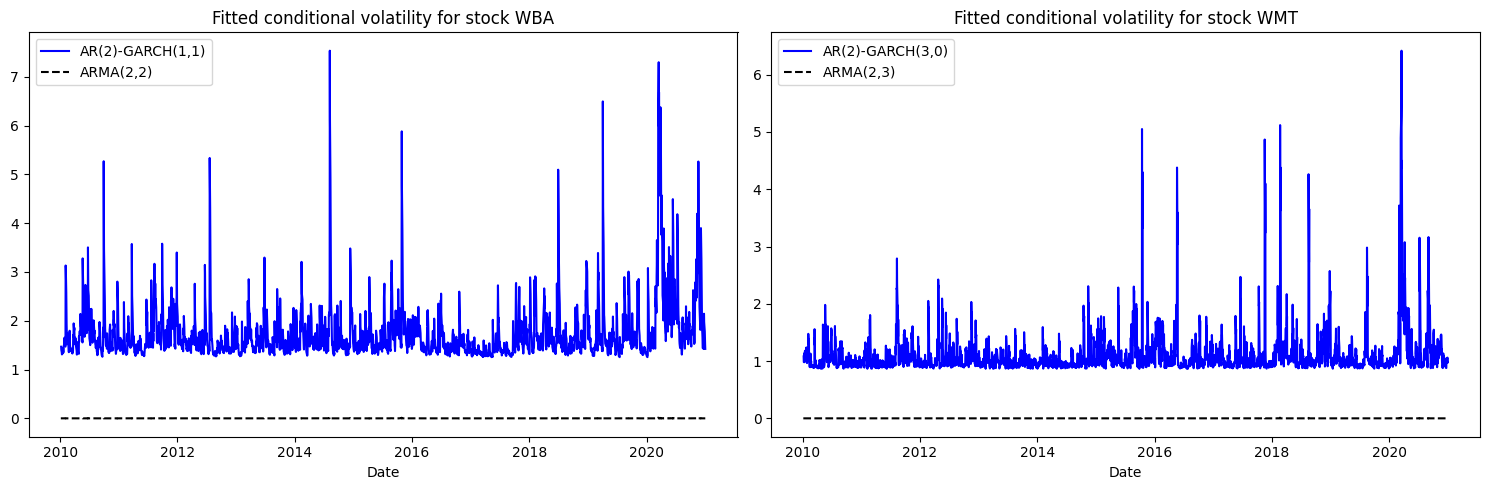

In [10]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
for i,ticker in enumerate(my_sample):
    conditional_volatility = garch_best_models[ticker]['model'].conditional_volatility
    axes[i].plot(conditional_volatility, color = 'blue', linestyle = '-', label=f'AR({best_models[ticker].order[0]})-GARCH({garch_best_models[ticker]['p']},{garch_best_models[ticker]['q']})')
    axes[i].plot(((best_models[ticker].resid()/100)**2), color = 'black', linestyle = '--', label = f'ARMA({best_models[ticker].order[0]},{best_models[ticker].order[2]})')
    axes[i].set_title(f'Fitted conditional volatility for stock {ticker}')
    axes[i].set_xlabel('Date')  
    axes[i].legend(loc='upper left')
plt.tight_layout()
plt.show()

# Task 3

### Task 3.1

In [11]:
data_oos = data.loc['2021-01-01':].copy()

fcast_for_each_stock_arma = {}

# Initialize one-step fcast for price
for ticker in my_sample:
    arima_p = SARIMAX(data_train[ticker]['return'],order=best_models[ticker].order,trend='c').fit(maxiter=200) 

    fcast_df = pd.DataFrame(index=data_oos.index)
    fcast_df[['f','fl','fu']] = np.nan

    for fdate in data_oos.index:
        # Step 1: Get an expanded in-sample data by one obs at a time
        y = data[ticker].loc[data[ticker].index < fdate, 'return']
        
        # Step 2: Apply the estimated model to the new data
        arima_p_ext = arima_p.apply(y, refit=False)
        
        # Step 3: Produce one-step ahead forecast
        fcast = arima_p_ext.get_forecast().summary_frame()[['mean','mean_ci_lower',  'mean_ci_upper']]

        # Save forecasts
        fcast_df.loc[fdate, ['f','fl','fu']] = np.array(fcast.iloc[0])
        
    fcast_for_each_stock_arma[ticker] = fcast_df

for ticker in my_sample:
    print(ticker)
    print(fcast_for_each_stock_arma[ticker].head())

WBA
                   f        fl        fu
Date                                    
2021-01-04  0.000030 -0.034738  0.034798
2021-01-05 -0.001254 -0.036022  0.033514
2021-01-06 -0.001647 -0.036415  0.033121
2021-01-07 -0.002015 -0.036783  0.032753
2021-01-08 -0.003449 -0.038217  0.031319
WMT
                   f        fl        fu
Date                                    
2021-01-04  0.000566 -0.022702  0.023834
2021-01-05 -0.001034 -0.024302  0.022234
2021-01-06  0.000886 -0.022382  0.024154
2021-01-07 -0.000212 -0.023480  0.023056
2021-01-08  0.000487 -0.022781  0.023755


### Task 3.2

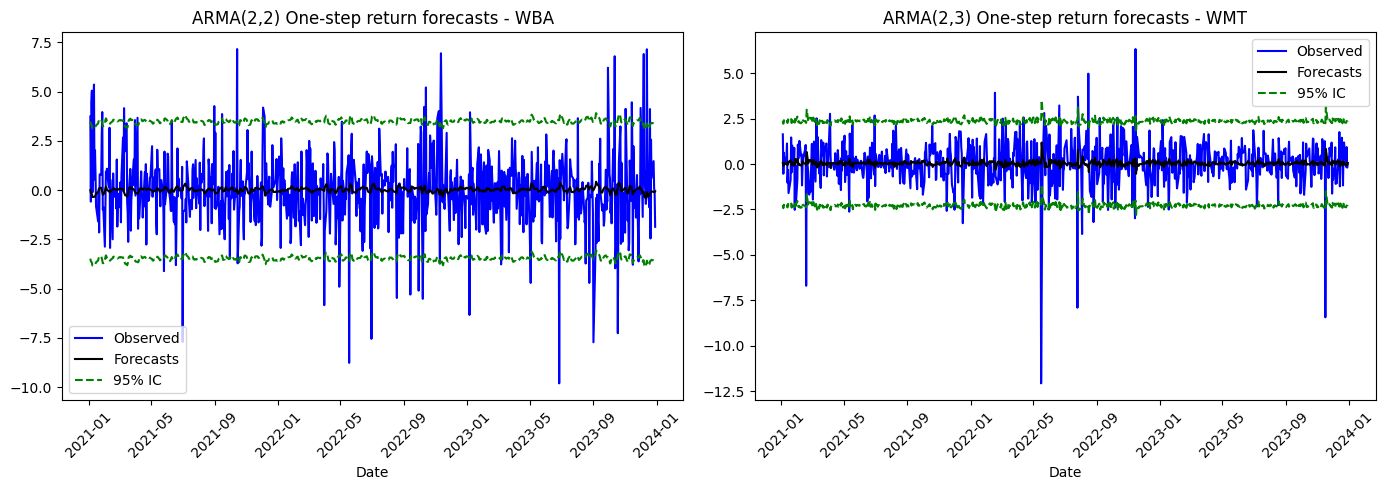

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (14,5))
for i,ticker in enumerate(my_sample):
    axes[i].plot(data_oos[ticker]['return']*100, c = 'blue', label = 'Observed')
    axes[i].plot(fcast_for_each_stock_arma[ticker]['f']*100, c = 'black', label = 'Forecasts')
    axes[i].plot(fcast_for_each_stock_arma[ticker]['fl']*100, c = 'green', linestyle = '--', label = '95% IC')
    axes[i].plot(fcast_for_each_stock_arma[ticker]['fu']*100, c = 'green', linestyle = '--')
    axes[i].set_title(f'ARMA({best_models[ticker].order[0]},{best_models[ticker].order[2]}) One-step return forecasts - {ticker}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('Date')
    axes[i].legend()


plt.tight_layout()
plt.show()

### Task 3.3

In [13]:
split_date = '2021-01-01'
fcast_for_each_stock_garch = {}

for i,ticker in enumerate(my_sample):
    garch = arch_model(y=data[ticker]['return']*100, mean='AR',lags=best_models[ticker].order[0],vol='GARCH',p=int(garch_best_models[ticker]['p']),o=0, q=garch_best_models[ticker]['q'])
    garch_fcast = garch.fit(last_obs = split_date, disp = 'off').forecast(reindex=False)

    r_true = 100*data[ticker].loc[data.index>=split_date,'return']
    f = garch_fcast.mean['h.1']
    var_fcast = garch_fcast.variance['h.1']
    fl = f - 1.96*var_fcast**0.5 # Lower bound 95%
    fu = f + 1.96*var_fcast**0.5 # Upper bound 95%

    fcast_df = pd.DataFrame({'f': f, 'fl': fl, 'fu': fu})
    fcast_for_each_stock_garch[ticker] = fcast_df.iloc[1:,:]

for ticker in my_sample:
    print(ticker)
    print(fcast_for_each_stock_garch[ticker].head())

WBA
                   f        fl        fu
Date                                    
2021-01-04 -0.094655 -4.255387  4.066076
2021-01-05 -0.129583 -3.783110  3.523943
2021-01-06 -0.024578 -5.036919  4.987764
2021-01-07 -0.241148 -6.224523  5.742227
2021-01-08 -0.190700 -5.160166  4.778765
WMT
                   f        fl        fu
Date                                    
2021-01-04 -0.014320 -2.432874  2.404234
2021-01-05 -0.000853 -2.044772  2.043066
2021-01-06  0.071258 -2.017194  2.159710
2021-01-07  0.033587 -1.768857  1.836032
2021-01-08  0.072673 -1.702523  1.847869


### Task 3.4

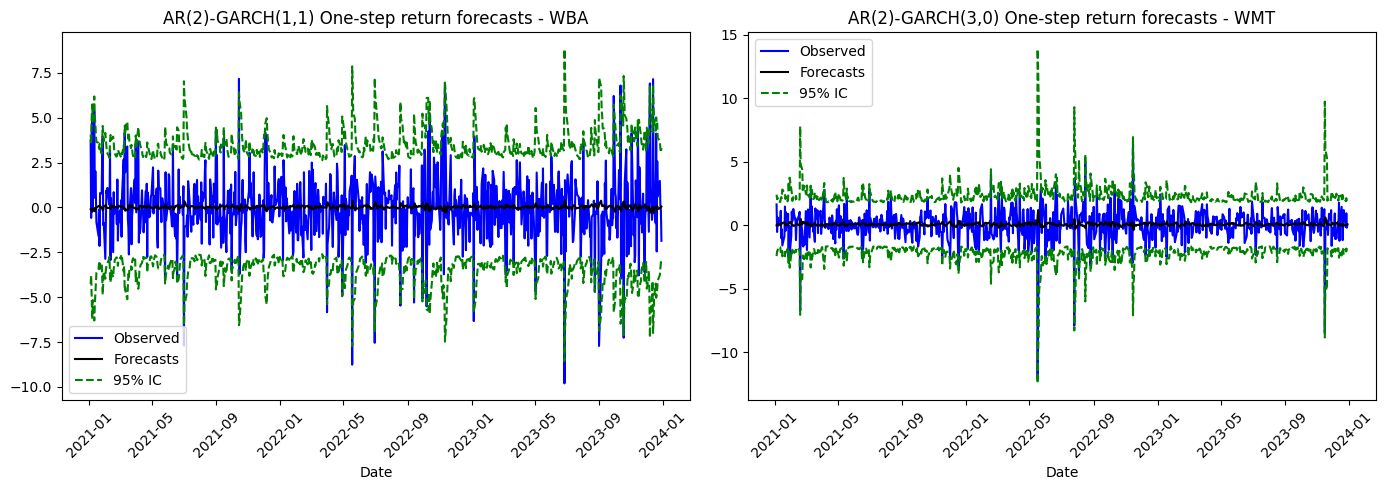

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (14,5))
for i,ticker in enumerate(my_sample):
    axes[i].plot(data_oos[ticker]['return']*100, c = 'blue', label = 'Observed')
    axes[i].plot(fcast_for_each_stock_garch[ticker]['f'], c = 'black', label = 'Forecasts')
    axes[i].plot(fcast_for_each_stock_garch[ticker]['fl'], c = 'green', linestyle = '--', label = '95% IC')
    axes[i].plot(fcast_for_each_stock_garch[ticker]['fu'], c = 'green', linestyle = '--')
    axes[i].set_title(f'AR({best_models[ticker].order[0]})-GARCH({garch_best_models[ticker]['p']},{garch_best_models[ticker]['q']}) One-step return forecasts - {ticker}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('Date')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Task 3.5

In [21]:
# Function to compute forecast accuracy measures
arma_p = best_models[ticker].order[0]
arma_q = best_models[ticker].order[2]

garch_p = garch_best_models[ticker]['p']
garch_q = garch_best_models[ticker]['q']

def forecast_accuracy(fcast, true, return_df=True):
    '''
    Input:
        fcast: a 1-D array-like object of forecasts
        true: a 1-D array-like object of true values, same length as fcast
        return_df: return output as a dataframe
    Output:
        MAE: Mean Absolute Error 
        RMSE: Root Mean Squared Error
    '''
    fcast = np.array(fcast)
    true = np.array(true)
    
    if len(fcast) != len(true):
        raise ValueError('`fcast` and `true` must have same length.')
    
    ferror = true - fcast
    MAE = np.mean(np.absolute(ferror))
    MSE = np.mean(ferror**2)

    mask = true != 0
    MAPE = np.mean(np.absolute((ferror[mask] / true[mask])))


    # MAPE = np.mean(np.absolute((ferror/true)))
    MASE =  MAE / np.mean(np.abs(np.diff(true)))

    
    out = {'MAE': MAE, 'MSE': MSE, 'MAPE': MAPE, 'MASE': MASE}
    if return_df:
        out = pd.DataFrame(out, index = [0])
    
    return out
    

accuracy_df = {}
arma_row = f'ARMA({arma_p},{arma_q})'
garch_row = f'AR({arma_p})-GARCH({garch_p},{garch_q})'

for ticker in my_sample:
    accuracy_arma = forecast_accuracy(fcast_for_each_stock_arma[ticker]['f']*100, data_oos[ticker]['return']*100)
    accuracy_garch = forecast_accuracy(fcast_for_each_stock_garch[ticker]['f'], data_oos[ticker]['return']*100)

    rough_df = pd.concat([accuracy_arma, accuracy_garch], ignore_index= True)
    rough_df.index = [arma_row, garch_row]
    accuracy_df[ticker] = rough_df


for ticker in my_sample:
    print(f'For {ticker}:')
    print(accuracy_df[ticker])

print()

for ticker in my_sample:
    arma_models = []
    garch_models = []
    print(f'For {ticker}:')
    for column in accuracy_df[ticker].columns:
        if accuracy_df[ticker][column][arma_row] < accuracy_df[ticker][column][garch_row]:
            arma_models.append(column)
        else:
            garch_models.append(column)
    
    print(f'Measures that ARMA({arma_p},{arma_q}) model produces smaller than AR({arma_p})-GARCH({garch_p},{garch_q}) \nmodel:',*arma_models)
    print(f'Measures that AR({arma_p})-GARCH({garch_p},{garch_q}) model produces smaller than ARMA({arma_p},{arma_q}) \nmodel:',*garch_models)
    print()

For WBA:
                       MAE       MSE      MAPE      MASE
ARMA(2,3)         1.379267  3.733894  1.055412  0.691436
AR(2)-GARCH(3,0)  1.399649  3.836734  1.045859  0.701654
For WMT:
                       MAE       MSE      MAPE      MASE
ARMA(2,3)         0.874715  1.704386  1.173872  0.714421
AR(2)-GARCH(3,0)  0.916741  1.874567  1.209916  0.748745

For WBA:
Measures that ARMA(2,3) model produces smaller than AR(2)-GARCH(3,0) 
model: MAE MSE MASE
Measures that AR(2)-GARCH(3,0) model produces smaller than ARMA(2,3) 
model: MAPE

For WMT:
Measures that ARMA(2,3) model produces smaller than AR(2)-GARCH(3,0) 
model: MAE MSE MAPE MASE
Measures that AR(2)-GARCH(3,0) model produces smaller than ARMA(2,3) 
model:



### Task 3.6

In [22]:
# Diebold-Mario test
def Diebold_Mario(floss1, floss2, h=1):
    '''
    Input:
        floss1: a 1-D array-like object of forecast losses (e.g. |e| or e^2) for model 1
        floss2: a 1-D array-like object of forecast losses for model 2
        h: forecast horizon
    Output:
        DM: DM statistic
        DM_pvalue: p-value of DM
        DMm: Harvey, Leybourne \& Newbold (1997) modified DM statistic
        DMm_pvalue: p-value for DMm
    '''
    import numpy as np
    import scipy.stats as scs
    
    floss1 = np.array(floss1)
    floss2 = np.array(floss2)
    
    if len(floss1) != len(floss2):
        raise ValueError('`floss1` and `floss2` must have same length.')
    if any(floss1<0) or any(floss2<0):
        raise ValueError('`floss1` and `floss2` must contain non-negative numbers.')
    
    # Loss differential
    d = floss1 - floss2
    T = len(d)
    
    # Mean loss differential
    d_mean = np.mean(d)
    
    # Find autocovariance and variance of mean loss differential
    def autocovariance(Xi, T, k, Xs):
        autoCov = 0
        for i in np.arange(0, T-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return autoCov/T
    
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d,T,lag,d_mean)) 
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    
    # Compute DM stats
    DM = d_mean/np.sqrt(V_d)
    harvey_factor=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DMm = harvey_factor*DM
    
    # Compute p-values
    DM_pvalue = 2*scs.norm.cdf(-abs(DM))
    DMm_pvalue = 2*scs.t.cdf(-abs(DMm), df = T - 1)
    
    return (DM,DM_pvalue,DMm,DMm_pvalue)



for ticker in my_sample:
    true = data_oos[ticker]['return']*100
    arma_fcast = fcast_for_each_stock_arma[ticker]['f']*100
    garch_fcast = fcast_for_each_stock_garch[ticker]['f']

    arma_abs_error = np.absolute(arma_fcast - true)
    garch_abs_error = np.absolute(garch_fcast - true)
    DM_MAE = Diebold_Mario(arma_abs_error, garch_abs_error)


    arma_sq_loss = (arma_fcast - true) ** 2
    garch_sq_loss = (garch_fcast - true) ** 2
    DM_MSE = Diebold_Mario(arma_sq_loss, garch_sq_loss)


    mask = true != 0
    arma_abs_perc_error = np.abs((arma_fcast - true)[mask] / true[mask])
    garch_abs_perc_error = np.abs((garch_fcast - true)[mask] / true[mask])
    DM_MAPE = Diebold_Mario(arma_abs_perc_error, garch_abs_perc_error)


    scaling_factor_arma = np.mean(np.abs(np.diff(true)))
    arma_scaled_error = arma_abs_error / scaling_factor_arma
    garch_scaled_error = garch_abs_error / scaling_factor_arma
    DM_MASE = Diebold_Mario(arma_scaled_error, garch_scaled_error)


    DM = pd.DataFrame({'MAE': DM_MAE[2:], 'MSE': DM_MSE[2:], 'MAPE': DM_MAPE[2:], 'MASE': DM_MASE[2:]},index=['DMm','pvalue'])
    accuracy_df[ticker] = pd.concat([accuracy_df[ticker],DM])

    print(accuracy_df[ticker])

print()
for ticker in accuracy_df.keys():
    print(f"For {ticker}:")
    
    for measure in ['MAE', 'MSE', 'MAPE', 'MASE']:
        dm_stat, p_value = accuracy_df[ticker][measure]['DMm'], accuracy_df[ticker][measure]['pvalue']
        
        if dm_stat > 0 and p_value < 0.05:
            print(f"Model ARMA({arma_p}, {arma_q}) produces significantly less accurate one-step return forecasts than model AR({arma_p})-GARCH({garch_p},{garch_q}) based on {measure}.")
        elif dm_stat < 0 and p_value < 0.05:
            print(f"Model ARMA({arma_p}, {arma_q}) produces significantly more accurate one-step return forecasts than model AR({arma_p})-GARCH({garch_p},{garch_q}) based on {measure}.")
        else:
            print(f"There is no significant difference in forecast accuracy between ARMA({arma_p}, {arma_q}) and AR({arma_p})-GARCH({garch_p},{garch_q}) based on {measure}.")
    print()


                           MAE           MSE      MAPE          MASE
ARMA(2,3)         1.379267e+00  3.733894e+00  1.055412  6.914363e-01
AR(2)-GARCH(3,0)  1.399649e+00  3.836734e+00  1.045859  7.016539e-01
DMm              -5.121751e+00 -5.690761e+00  0.702681 -5.121751e+00
pvalue            3.850048e-07  1.812393e-08  0.482474  3.850048e-07
                           MAE           MSE      MAPE          MASE
ARMA(2,3)         8.747154e-01  1.704386e+00  1.173872  7.144207e-01
AR(2)-GARCH(3,0)  9.167410e-01  1.874567e+00  1.209916  7.487449e-01
DMm              -1.606337e+01 -5.710217e+00 -1.499228 -1.606337e+01
pvalue            3.857388e-50  1.624574e-08  0.134234  3.857388e-50

For WBA:
Model ARMA(2, 3) produces significantly more accurate one-step return forecasts than model AR(2)-GARCH(3,0) based on MAE.
Model ARMA(2, 3) produces significantly more accurate one-step return forecasts than model AR(2)-GARCH(3,0) based on MSE.
There is no significant difference in forecast accuracy 